In [1]:
import os, sys, pandas as pd
import torch.nn as nn
sys.path.append("/content")
from src.utils import fit_mlp, plot_obs_predict

with open("/content/credentials") as f:
    env_vars = f.read().split("\n")

for var in env_vars:
    key, value = var.split(" = ")
    os.environ[key] = value

storage_options = {"account_name":os.environ["ACCOUNT_NAME"],
                   "account_key":os.environ["BLOB_KEY"]}


In [6]:
# Specify hyperparameters and fit model
buffer_distance = 500
day_tolerance = 8
cloud_thr = 80
min_water_pixels = 50
features = [
    "Intercept", "sentinel-2-l2a_AOT", 
    "sentinel-2-l2a_B02", "sentinel-2-l2a_B03", "sentinel-2-l2a_B04", # RGB bands
    "sentinel-2-l2a_B08", # NIR
    #"sentinel-2-l2a_WVP", 
    "sentinel-2-l2a_B05", "sentinel-2-l2a_B06", "sentinel-2-l2a_B07", "sentinel-2-l2a_B8A",  # Red edge bands
    "is_brazil", "sine_julian", 
    "sentinel-2-l2a_B11", "sentinel-2-l2a_B12", # SWIR
    "mean_viewing_azimuth", "mean_viewing_zenith",
    "mean_solar_azimuth", "mean_solar_zenith"
]
epochs = 500
batch_size = 64
learning_rate = 0.01

layer_out_neurons = [24, 48, 12, 36, 9]
n_layers = len(layer_out_neurons)

model_out = fit_mlp(
    features,
    learning_rate,
    batch_size,
    epochs,
    storage_options,
    buffer_distance=buffer_distance,
    day_tolerance=day_tolerance,
    cloud_thr=cloud_thr,
    mask_method="lulc",
    min_water_pixels=min_water_pixels,
    n_layers=n_layers,
    layer_out_neurons=layer_out_neurons
)

KeyError: "['sentinel-2-l2a_B12'] not in index"

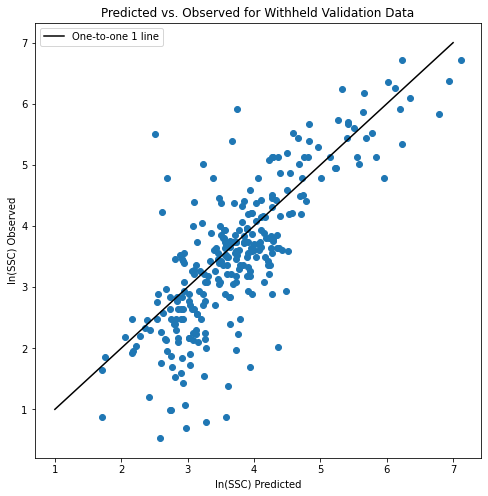

In [3]:
# Plot observed vs predicted for Test data
plot_obs_predict(
    model_out["val_obs_predict"],
    title="Predicted vs. Observed for Withheld Validation Data",
    savefig=False)

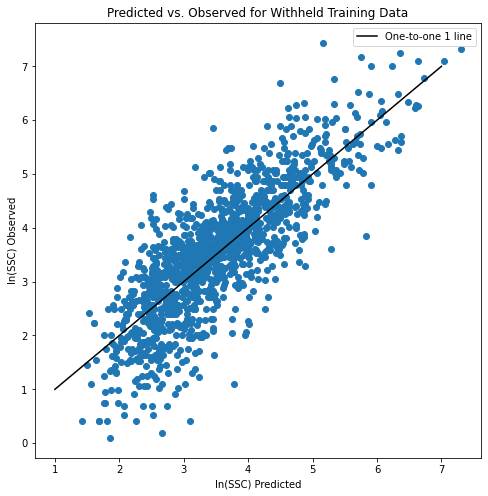

In [4]:
# Plot observed vs predicted for Train data
plot_obs_predict(
    model_out["train_obs_predict"],
    title="Predicted vs. Observed for Withheld Training Data",
    savefig=False)

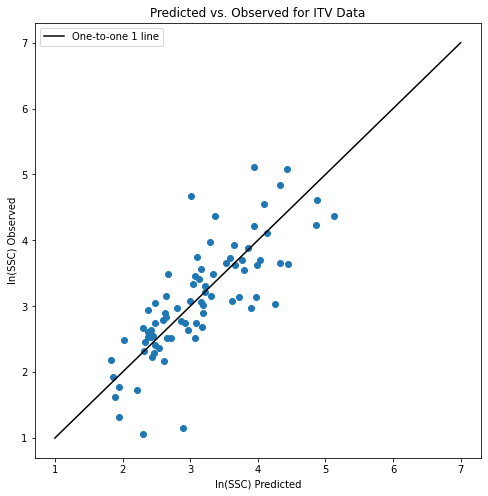

In [5]:
# Plot observed vs predicted for ITV data
plot_obs_predict(
    model_out["itv_obs_predict"],
    title="Predicted vs. Observed for ITV Data",
    savefig=False)

In [7]:
print(model_out["train_R2"])
print(model_out["val_R2"])
print(model_out["itv_R2"])

0.4687303738032158
0.4821257528531231
0.5220520907319179
